# Sports Image Classification

Dataset Citation:

gpiosenka, 100 Sports Image Classification, Kaggle, 2023. https://www.kaggle.com/datasets/gpiosenka/sports-classification?select=test.

Model Citation:

Simonyan, Karen \& Zisserman, Andrew. Very Deep Convolutional Networks for Large-Scale Image Recognition, arXiv, 4 September 2014. https://arxiv.org/abs/1409.1556.

* Load in all necessary packages and functions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from absl import logging
import os
import warnings

# resolve some unnecessary warnings displayed by tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
logging.set_verbosity(logging.ERROR)

* We have a folder named "Data" that has 4 sub-folders named "baseball", "basketball", "football", and "hockey" that contain our images. We will create a dataframe that allows us to split these images into train, test, and validation sets.

In [16]:
# we have 184 baseball images, 179 baseball images, 201 football, 182 hockey images
sports_info = [("baseball", 184, 0), ("basketball", 179, 1), ("football", 201, 2), ("hockey", 182, 3)]
sports_dfs = []

for sport, num_images, classid in sports_info:
    # 70% train, 15% validation, 15% test
    train_indices, temp_indices = train_test_split(np.arange(num_images), test_size=0.3, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
    
    # create a datframe for the train data files
    train_df = pd.DataFrame({"filepath":[f"Data/{sport}/{i:0>3}.jpg" for i in train_indices + 1], "dataset":"train", "label":sport, "classid":classid})
    sports_dfs.append(train_df)

    # create a datframe for the validation data files
    val_df = pd.DataFrame({"filepath":[f"Data/{sport}/{i:0>3}.jpg" for i in val_indices + 1], "dataset":"validation", "label":sport, "classid":classid})
    sports_dfs.append(val_df)

    # create a datframe for the test data files
    test_df = pd.DataFrame({"filepath":[f"Data/{sport}/{i:0>3}.jpg" for i in test_indices + 1], "dataset":"test", "label":sport, "classid":classid})
    sports_dfs.append(test_df)

sports = pd.concat(sports_dfs, axis=0, ignore_index=True)
sports["classid"] = sports["classid"].astype(int)
sports.to_csv('Data/sports.csv', index=False)

* We will now create the train, test, and validation sets that will be used for our model.

In [17]:
sports = pd.read_csv("Data/sports.csv")

# set image size and batch size
IMG_SIZE = (128, 128)  # resize images to 128x128
BATCH_SIZE = 32

# create an ImageDataGenerator for data augmentation to improve generalization
datagen = ImageDataGenerator(
    rescale = 1. / 255,  # normalize pixel values to [0, 1]
    rotation_range = 180, # add random rotations to the images
    horizontal_flip = True # add horizontal flips to some images
)

train_df = sports[sports['dataset'] == 'train']
val_df = sports[sports['dataset'] == 'validation']
test_df = sports[sports['dataset'] == 'test']

# train data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # one-hot encode the labels
    shuffle=True # shuffle the train data
)
# validation data generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # one-hot encode the labels
    shuffle=False  # do not shuffle validation data
)
# test data generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # one-hot encode the labels
    shuffle=False # do not shuffle test data
)

Found 520 validated image filenames belonging to 4 classes.
Found 112 validated image filenames belonging to 4 classes.
Found 114 validated image filenames belonging to 4 classes.


* We will now display some of our images with the rotations and flips we applied. When the images are used un the model, they will not be in color because we normalized the pizel values, but we display them in color here for better viewing.

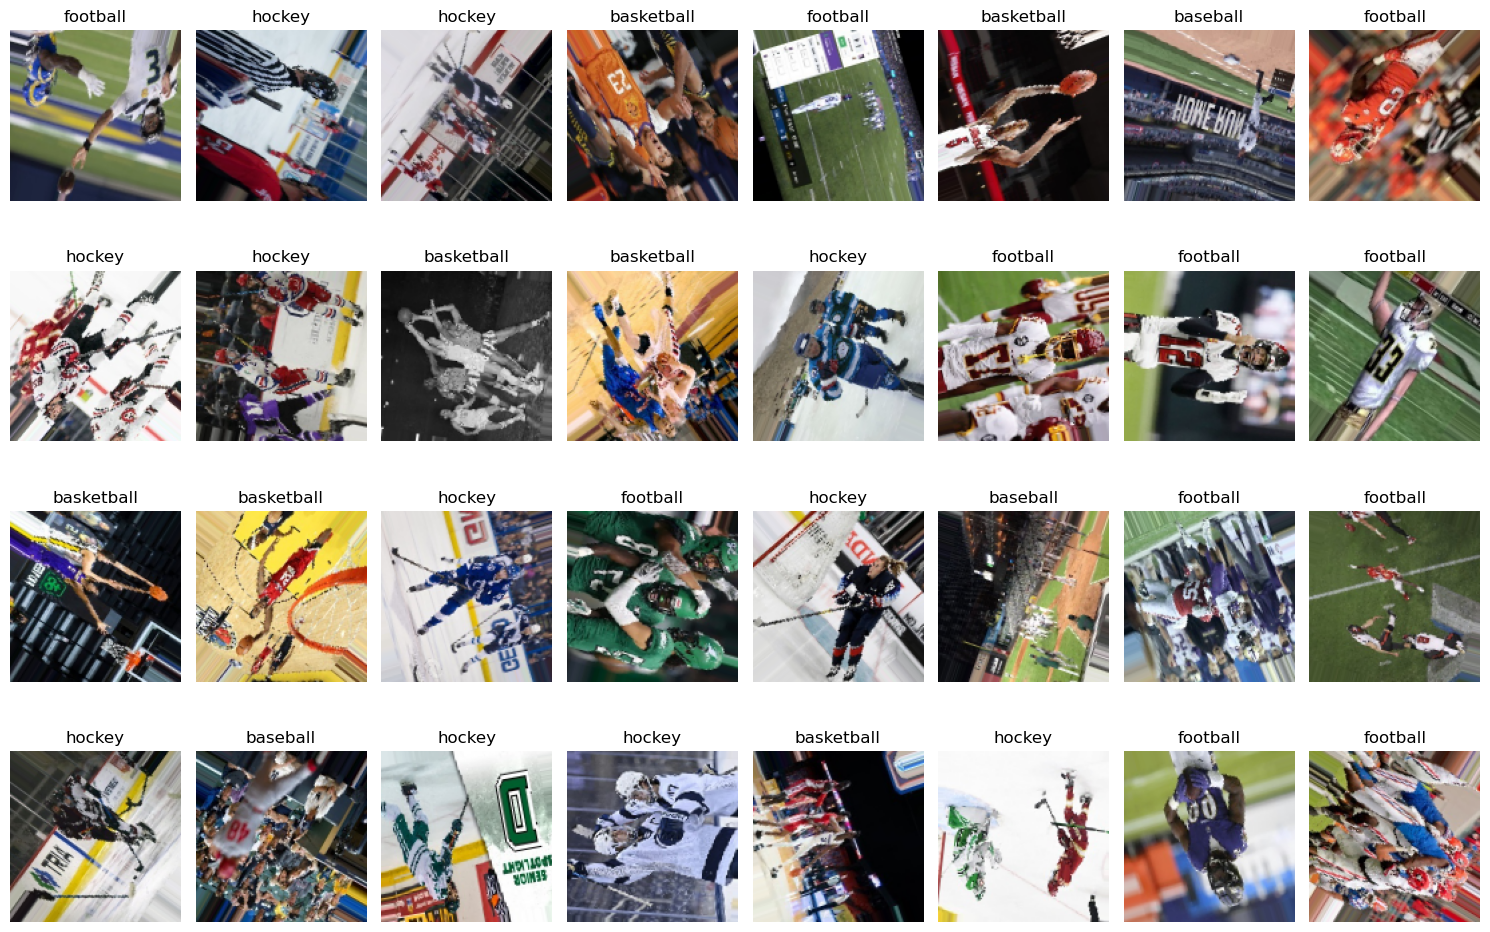

In [18]:
images, labels = next(train_generator)
sport_types = ["baseball", "basketball", "football", "hockey"]

# we will display the first 32 images in our training data
cols = 8
rows = 4

plt.figure(figsize=(15, 10))
for i in range(32):
    plt.subplot(rows, cols, i + 1)
    plt.imshow((images[i] * 255).astype('uint8'))  # change the pixel colors to not be just in [0,1]
    plt.axis('off')
    plt.title(sport_types[np.argmax(labels[i])])  # label each image with its sport

plt.tight_layout()
plt.show()

* We now move on to model training. We will use the VGG16 model architecture with some improvements for our dataset. The model architecture is displayed here: 

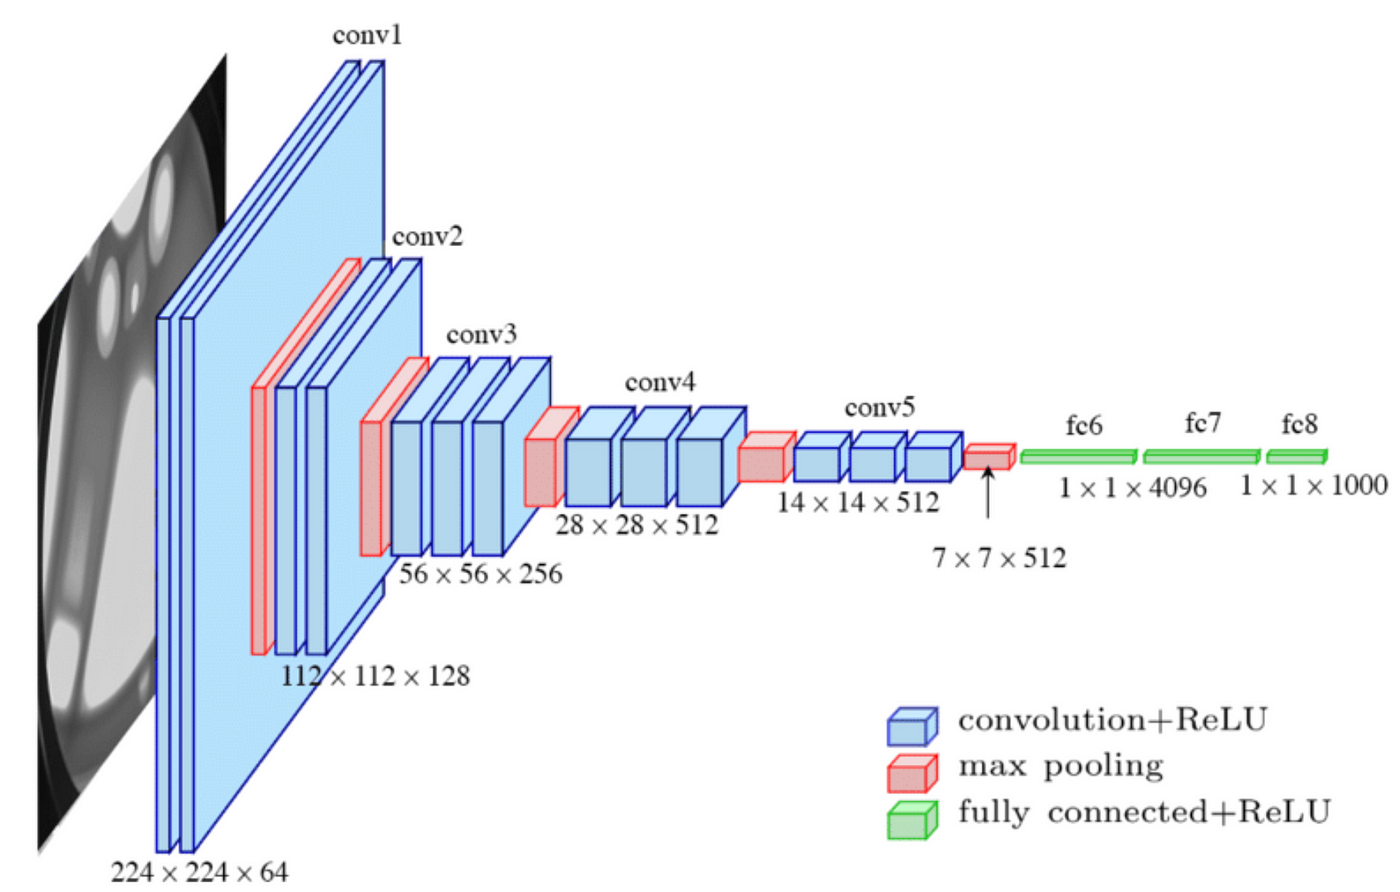

* We add a global average pooling 2D layer, a dropout layer, and an output layer to make the model work for our data.
* We use the Adam loss function with learning rate 0.0001 as our optimizer and categorical cross entropy as our loss function.

In [19]:
# Pre-Trained Model VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True # make it so the model is fitted to our data

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# create a stopping condition for the fitting of the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks = [callback],
    epochs=20
)

Epoch 1/20
16/16 [==============================] - 37s 2s/step - loss: 1.3727 - accuracy: 0.3135 - val_loss: 1.2060 - val_accuracy: 0.4271
Epoch 2/20
16/16 [==============================] - 36s 2s/step - loss: 1.0813 - accuracy: 0.5123 - val_loss: 1.0576 - val_accuracy: 0.5521
Epoch 3/20
16/16 [==============================] - 37s 2s/step - loss: 0.9596 - accuracy: 0.5779 - val_loss: 1.0634 - val_accuracy: 0.5104
Epoch 4/20
16/16 [==============================] - 36s 2s/step - loss: 0.8804 - accuracy: 0.6455 - val_loss: 0.8599 - val_accuracy: 0.6354
Epoch 5/20
16/16 [==============================] - 36s 2s/step - loss: 0.7648 - accuracy: 0.6803 - val_loss: 0.7486 - val_accuracy: 0.7292
Epoch 6/20
16/16 [==============================] - 37s 2s/step - loss: 0.6380 - accuracy: 0.7766 - val_loss: 0.6158 - val_accuracy: 0.7500
Epoch 7/20
16/16 [==============================] - 37s 2s/step - loss: 0.5737 - accuracy: 0.7561 - val_loss: 0.6046 - val_accuracy: 0.7188
Epoch 8/20
16/16 [==

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 14,780,868
Trainable params: 14,780,868
Non-trainable params: 0
__________________________________________

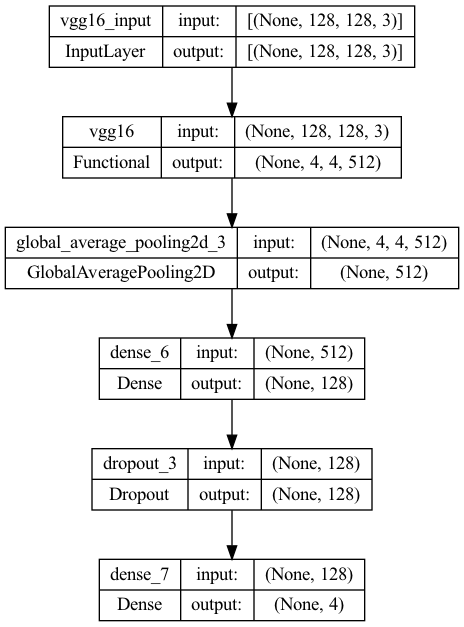

In [22]:
import keras
# plot the model layers in a flow chart format
keras.utils.plot_model(model, "model.png",
                       show_shapes=True,
                       show_layer_names=True)

* We will now display the training and validation accuracy for each epoch of the dataset.

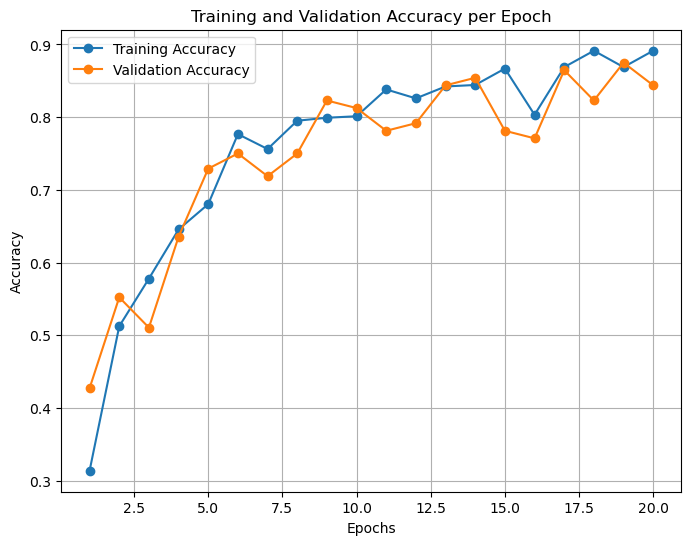

In [36]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

* We save the model for future usage.

In [42]:
model.save('sports_classifier_model.h5')

* Print the test accuracy of the model.

In [39]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

3/3 [==============================] - 2s 598ms/step - loss: 0.4902 - accuracy: 0.8542
Test Accuracy: 85.42%


* Display the confusion matrix.

4/4 [==============================] - 2s 523ms/step


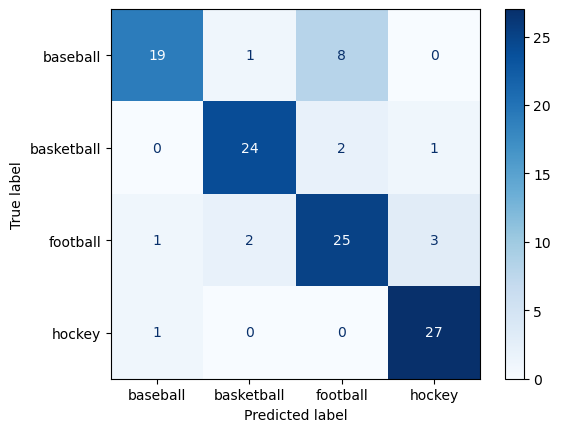

In [40]:
test_preds = np.argmax(model.predict(test_generator), axis = 1)
test_true = test_generator.labels
class_names = ["baseball", "basketball", "football", "hockey"]

# Compute the confusion matrix
cm = confusion_matrix(test_true, test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Replace class_names with your class labels
disp.plot(cmap='Blues')

* The model does not perform well in one case: it predicts football for a lot of baseball images. This is liekly due to the fact that they are both played on grass, wheras basketball and hockey are played on hardwood and ice respectively.